In [1]:
## Inspiration: https://towardsdatascience.com/identify-your-datas-distribution-d76062fc0802

In [1]:
from scipy.stats import *

In [2]:
import re
import pandas as pd
import numpy as np
# from mlutils import dataset, connector
import scipy.stats
from scipy.stats import *
from sklearn.preprocessing import StandardScaler
import math
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm 
import seaborn as sns
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
df = pd.read_csv('credit_data.csv')

In [4]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
df.shape

(1000, 10)

In [6]:
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [7]:
df.columns


Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [18]:
columns = ['Age','Credit amount','Duration']

In [19]:
df = df[columns]

In [22]:
df.rename(columns={"Credit amount":"Amount"}, inplace=True)

In [23]:
df

,Age,Amount,Duration
0,67,1169,6
1,22,5951,48
2,49,2096,12
3,45,7882,42
4,53,4870,24
...,...,...,...
995,31,1736,12
996,40,3857,30
997,38,804,12
998,23,1845,45


In [24]:
df.describe()

,Age,Amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [25]:
df.isna().sum()

Age         0
Amount      0
Duration    0
dtype: int64

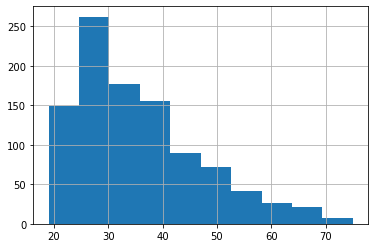

In [26]:
df['Age'].hist()

In [27]:
def standarise(column,pct,pct_lower):
    sc = StandardScaler() 
    y = df[column][df[column].notnull()].to_list()
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

In [28]:
def fit_distribution(column,pct,pct_lower):
    # Set up list of candidate distributions to use
    # See https://docs.scipy.org/doc/scipy/reference/stats.html for more
    y_std,size,y_org = standarise(column,pct,pct_lower)
    dist_names = ['weibull_min','norm','weibull_max','beta',
                 'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']

    chi_square_statistics = []
    # 11 bins
    percentile_bins = np.linspace(0,100,11)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)
        print("{}\n{}\n".format(dist, param))
      

        # Get expected counts in percentile bins
        # cdf of fitted sistrinution across bins
        cdf_fitted = dist.cdf(percentile_cutoffs, *param)
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # Chi-square Statistics
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = round(sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency),0)
        chi_square_statistics.append(ss)


    #Sort by minimum ch-square statistics
    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square_statistics
    results.sort_values(['chi_square'], inplace=True)


    print ('\nDistributions listed by Betterment of fit:')
    print ('............................................')
    print (results)

In [30]:
fit_distribution('Age',0.99,0.01)

(1.4612310893407063, -1.438287263338653, 1.5890726910603103)

(1.740104659004327e-16, 1.0)

(0.7523396580418977, 2.944037940340311, 1.2342532789810878)

(1.501092647956237, 5.6612991757992654, -1.4381897208106194, 6.879347375691821)

(0.3492791416636787, -1.8352934608765303, 5.2545163880960395)

(-1.4257219053697532, 4.369759845710064)

(1.9665711191801103, -1.4612186664260212, 0.7430289301848985)

(-1.4257219053697532, 1.4257219053697534)

(0.582494788183183, -1.7649796162457139, 1.5007693942563)

(1.426198418944911, 1.0194405000289608e-16, 1.0420018054812412)

(0.07102011954161436, -1.4682718596928335, 4.526474714946129)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
0   weibull_min         7.0
3          beta         8.0
6         gamma         8.0
8       lognorm         8.0
9      pearson3         8.0
4      invgauss         9.0
10       triang        30.0
1          norm       242.0
7         expon       390.0

In [31]:
y_std,len_y,y = standarise('Age',0.99,0.01)

Text(0, 0.5, 'Frequency')

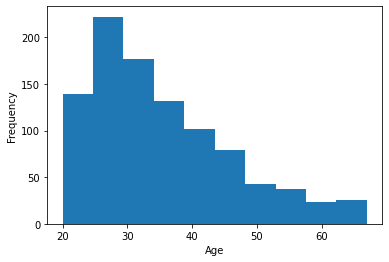

In [32]:
plt.hist(y)
plt.xlabel('Age')
plt.ylabel('Frequency')

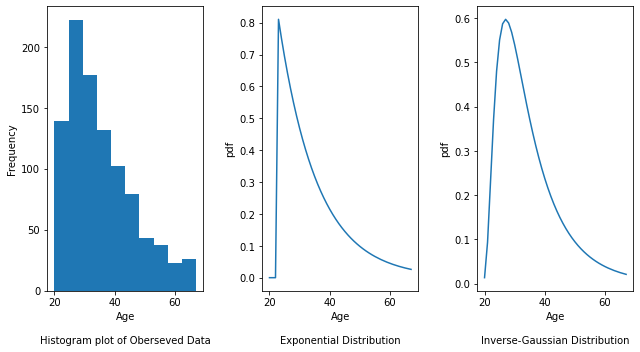

In [37]:
# f = plt.figure()
# plt.subplot(y,expon.pdf(y_std,-1.19, 1.19))
# plt.subplot(y,invgauss.pdf(y_std,0.45, -1.64, 3.61))
# f.show()


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel('Age\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')
axes[1].plot(y,expon.pdf(y_std,-1.19, 1.19))
axes[1].set_xlabel('Age\n\nExponential Distribution')
axes[1].set_ylabel('pdf')
axes[2].plot(y,invgauss.pdf(y_std,0.45, -1.64, 3.61))
axes[2].set_xlabel('Age\n\nInverse-Gaussian Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

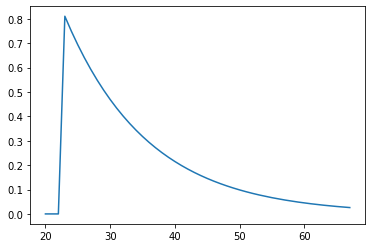

In [38]:
f = plt.figure()
plt.plot(y,expon.pdf(y_std,-1.19, 1.19))
f.show()

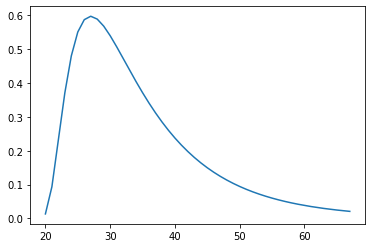

In [39]:
f = plt.figure()
plt.plot(y,invgauss.pdf(y_std,0.45, -1.64, 3.61))
f.show()

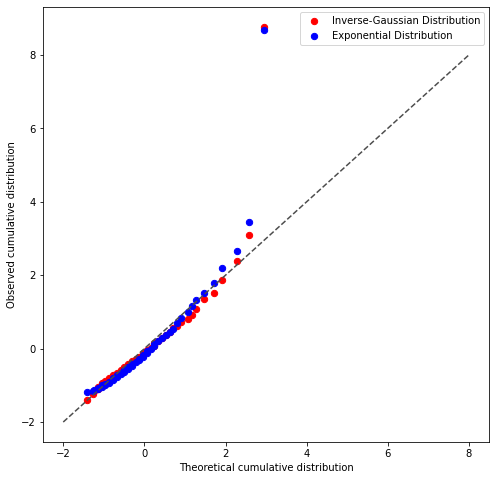

In [40]:
data_points = expon.rvs(-1.19, 1.19, size=2000)   
data_points2 = invgauss.rvs(0.45, -1.64, 3.61,size = 2000) 

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

percentile_bins = np.linspace(0,100,51)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)
percentile_cutoffs_expon= np.percentile(data_points, percentile_bins)


percentile_cutoffs_invgauss = np.percentile(data_points2, percentile_bins)


ax.scatter(percentile_cutoffs1,percentile_cutoffs_invgauss,c='r',label = 'Inverse-Gaussian Distribution',s = 40)
ax.scatter(percentile_cutoffs1,percentile_cutoffs_expon,c='b',label = 'Exponential Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()


In [58]:
fit_distribution('Amount',0.99,0.01)

(1.1402301701293607, -1.0794479386218432, 1.1344877076778805)

(0.0, 1.0)

(400606349.9927365, 246314663.80002666, 246314664.2101654)

(0.9423212512613772, 3.753786146867025, -1.07908037902575, 5.9363486016248395)

(0.7923493330492724, -1.2065084460295652, 1.5227057930241261)

(-1.0790803790257497, 5.3949916049512385)

(1.313724343160756, -1.0807980678220743, 0.8227154553508798)

(-1.0790803790257497, 1.0790803790257497)

(0.8464343364774161, -1.148206411013768, 0.8154583162681766)

(1.7448713827086892, -0.001999196800772596, 0.9411796971452548)

(0.019798608315855164, -1.1070214685588842, 5.433929870188182)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
4      invgauss         3.0
8       lognorm         3.0
6         gamma        19.0
9      pearson3        19.0
0   weibull_min        26.0
3          beta        78.0
7         expon        82.0
2   weibull_max       209.0
10       triang       768.0
1          nor

In [59]:
y_std,len_y,y = standarise('Amount',0.99,0.01)

Text(0, 0.5, 'Frequency')

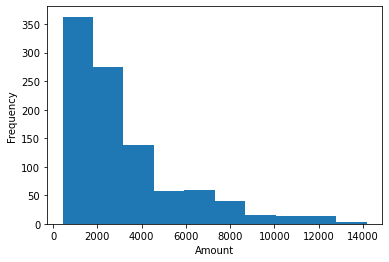

In [51]:
plt.hist(y)
plt.xlabel('Amount')
plt.ylabel('Frequency')

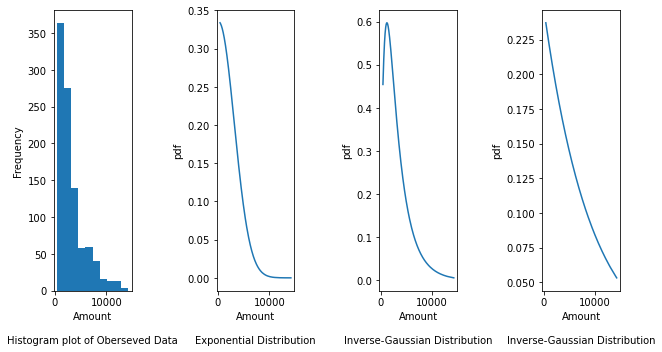

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(9, 5))
axes[0].hist(y)
axes[0].set_xlabel('Amount\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')

axes[1].plot(y,norm.pdf(y_std,-1.19, 1.19))
axes[1].set_xlabel('Amount\n\nExponential Distribution')
axes[1].set_ylabel('pdf')

axes[2].plot(y,invgauss.pdf(y_std,0.45, -1.64, 3.61))
axes[2].set_xlabel('Amount\n\nInverse-Gaussian Distribution')
axes[2].set_ylabel('pdf')

axes[3].plot(y,expon.pdf(y_std,-1.64, 3.61))
axes[3].set_xlabel('Amount\n\nInverse-Gaussian Distribution')
axes[3].set_ylabel('pdf')

fig.tight_layout()

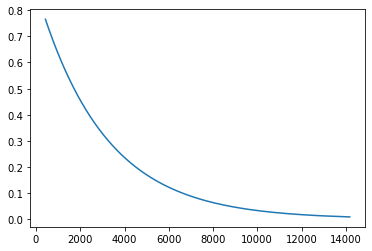

In [56]:
f = plt.figure()
plt.plot(y,expon.pdf(y_std,-1.19, 1.19))
f.show()

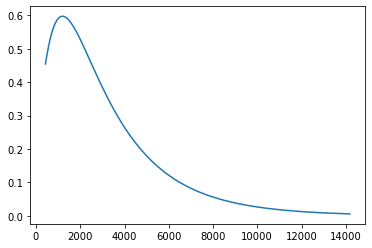

In [85]:
f = plt.figure()
plt.plot(y,invgauss.pdf(y_std,0.45, -1.64, 3.61))
f.show()

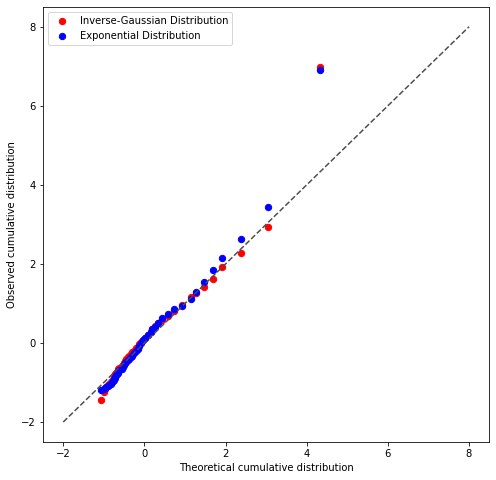

In [57]:
data_points = expon.rvs(-1.19, 1.19, size=2000)   
data_points2 = invgauss.rvs(0.45, -1.64, 3.61,size = 2000) 

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 8], [-2, 8], ls="--", c=".3")

percentile_bins = np.linspace(0,100,51)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)
percentile_cutoffs_expon= np.percentile(data_points, percentile_bins)


percentile_cutoffs_invgauss = np.percentile(data_points2, percentile_bins)


ax.scatter(percentile_cutoffs1,percentile_cutoffs_invgauss,c='r',label = 'Inverse-Gaussian Distribution',s = 40)
ax.scatter(percentile_cutoffs1,percentile_cutoffs_expon,c='b',label = 'Exponential Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()


In [41]:
fit_distribution('Duration',0.99,0.01)

(1.2472726376041416, -1.3252495110406186, 1.4151916731058156)

(5.800348863347757e-17, 1.0)

(0.6882623452750762, 3.466842524623189, 1.264111129256917)

(0.8700074141284213, 4.187244124003745, -1.291568783683149, 7.779824138552)

(0.33007481315353937, -1.869400426837919, 5.66357347961901)

(-1.2915687836831489, 4.7584113083063375)

(1.4343683313309845, -1.343809964879716, 0.9368663251678974)

(-1.2915687836831489, 1.2915687836831489)

(0.5649425864841316, -1.803291049269092, 1.5469953709639799)

(1.6698468236683572, 2.5242119406682785e-17, 1.1219910413032657)

(0.0021389910496024817, -1.3018683351610463, 4.815129319807777)


Distributions listed by Betterment of fit:
............................................
   Distribution  chi_square
10       triang        53.0
8       lognorm        59.0
4      invgauss        64.0
0   weibull_min       153.0
6         gamma       169.0
9      pearson3       169.0
1          norm       174.0
3          beta       376.0
7         expon       522.0

In [42]:
lst,len_lst,org_lst = standarise('Duration',0.99,0.01)

In [43]:
org_lst[:20]

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

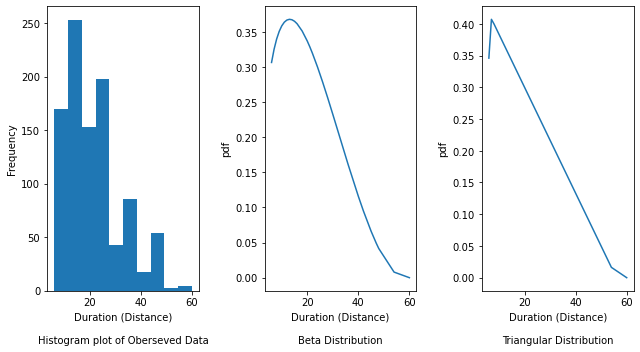

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
axes[0].hist(org_lst)
axes[0].set_xlabel('Duration (Distance)\n\nHistogram plot of Oberseved Data')
axes[0].set_ylabel('Frequency')
axes[1].plot(org_lst,beta.pdf(lst,1.51, 2.94, -1.71, 5.02))
axes[1].set_xlabel('Duration (Distance)\n\nBeta Distribution')
axes[1].set_ylabel('pdf')
axes[2].plot(org_lst,triang.pdf(lst,.12, -1.79, 4.90))
axes[2].set_xlabel('Duration (Distance)\n\nTriangular Distribution')
axes[2].set_ylabel('pdf')
fig.tight_layout()

(array([170., 253., 153., 198.,  43.,  86.,  17.,  54.,   2.,   4.]),
 array([ 6. , 11.4, 16.8, 22.2, 27.6, 33. , 38.4, 43.8, 49.2, 54.6, 60. ]),
 <a list of 10 Patch objects>)

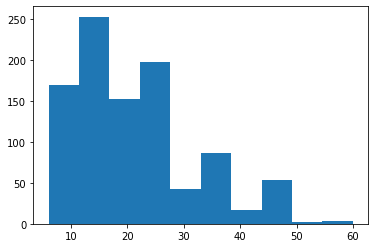

In [46]:
plt.hist(org_lst)

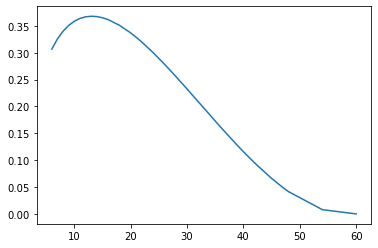

In [47]:
f = plt.figure()
plt.plot(org_lst,beta.pdf(lst,1.5111609633771699, 2.9428574390909983, -1.712121634564888, 5.022935095746597))
f.show()

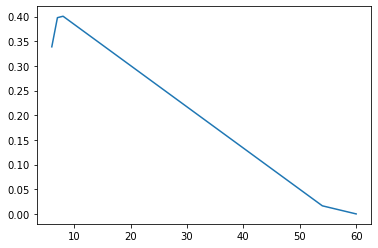

In [48]:
f = plt.figure()
plt.plot(org_lst,triang.pdf(lst,.12388009897125515, -1.7967712548899337, 4.908020533304843))
f.show()

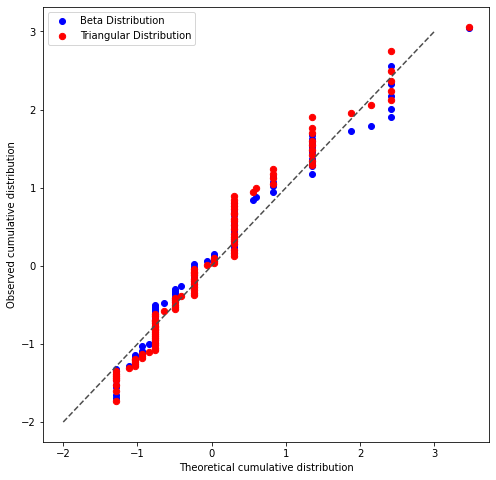

In [49]:
data_points = beta.rvs(1.51, 2.94, -1.71, 5.02,size = 1000)    
  
data_points2 = triang.rvs(.12, -1.79, 4.90,size = 1000) 

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 3], [-2, 3], ls="--", c=".3")

percentile_bins = np.linspace(0,100,101)
percentile_cutoffs1 = np.percentile(lst, percentile_bins)
percentile_cutoffs_beta = np.percentile(data_points, percentile_bins)


percentile_cutoffs_triang = np.percentile(data_points2, percentile_bins)
# print(percentile_cutoffs1,percentile_cutoffs2)

ax.scatter(percentile_cutoffs1,percentile_cutoffs_beta,c='b',label = 'Beta Distribution')
ax.scatter(percentile_cutoffs1,percentile_cutoffs_triang,c='r',label = 'Triangular Distribution',s = 40)


ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
ax.legend()
plt.show()
